In [1]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available ? :  True


In [2]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
with open('../../Data/movie_201118_table_6.pickle', 'rb') as f:
    data = pickle.load(f)

In [6]:
data = data[['sa_id', 'movie_meta_price', 'label']]

In [5]:
sparse_features = ['sa_id'
#                    'album_id',
#                    'buy_seg'
                  ]
dense_features = ['movie_meta_price'
#                   , 'run_time', 'release_date', 'i30_meta_price', 'buy_tot',
#                   'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4'
                 ]
target = ['label']

In [6]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [7]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [8]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [9]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=2**16, epochs=200, verbose=1, validation_split=0.2,
                   callbacks=[callback])

Epoch 1/200


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


153/153 [==============================] - 3s 22ms/step - loss: 0.6936 - binary_crossentropy: 0.6934 - val_loss: 0.6938 - val_binary_crossentropy: 0.6937
Epoch 2/200
153/153 [==============================] - 3s 19ms/step - loss: 0.6936 - binary_crossentropy: 0.6933 - val_loss: 0.6941 - val_binary_crossentropy: 0.6938
Epoch 3/200
153/153 [==============================] - 3s 19ms/step - loss: 0.6936 - binary_crossentropy: 0.6932 - val_loss: 0.6942 - val_binary_crossentropy: 0.6939
Epoch 4/200
153/153 [==============================] - 3s 19ms/step - loss: 0.6936 - binary_crossentropy: 0.6932 - val_loss: 0.6942 - val_binary_crossentropy: 0.6939
Epoch 5/200
153/153 [==============================] - 3s 19ms/step - loss: 0.6936 - binary_crossentropy: 0.6932 - val_loss: 0.6942 - val_binary_crossentropy: 0.6939
Epoch 6/200
153/153 [==============================] - 3s 19ms/step - loss: 0.6936 - binary_crossentropy: 0.6932 - val_loss: 0.6942 - val_binary_crossentropy: 0.6939


In [12]:
pred_ans = model.predict(test_model_input, batch_size=2**16)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.6939
test AUC 0.3646


In [13]:
import matplotlib.pyplot as plt

(array([2.190000e+02, 2.504000e+03, 2.316400e+04, 1.886220e+05,
        1.285585e+06, 1.389089e+06, 1.977700e+05, 2.375600e+04,
        3.434000e+03, 3.110000e+02]),
 array([0.48680583, 0.48939005, 0.49197423, 0.49455845, 0.49714267,
        0.4997269 , 0.5023111 , 0.50489527, 0.5074795 , 0.5100637 ,
        0.5126479 ], dtype=float32),
 <a list of 10 Patch objects>)

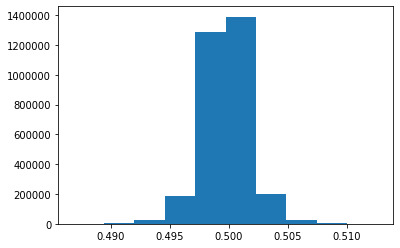

In [14]:
plt.hist(pred_ans)

In [1]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets
